In [2]:
import tensorflow as tf                                     #import required libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import logging
import cv2
from sklearn.preprocessing import StandardScaler

# Load Images and convert into NP Array

In [3]:
import os
from PIL import Image
folder_path =  r"SAUNAR"                                        # location of data folder
y=[]    #output
X=[]    #input
c=0
for fldr in os.listdir(folder_path):                            #open folder
    sub_folder_path = os.path.join(folder_path, fldr)
    for filee in os.listdir(sub_folder_path):                   #open subfolders
        file_path = os.path.join(sub_folder_path, filee)
        print('** Path: {}  **'.format(file_path), end="\r", flush=True)
        im = Image.open(file_path)                              #open image
        im = im.resize((256,256),Image.ANTIALIAS)               #resize image to (256 X 256 pixels)
        rgb_im = im.convert('RGB')                              #convert format to RGB
        array = np.array(tf.keras.utils.img_to_array(rgb_im))   #convert image to array
        if(c==0 or c==1):
            y.append(0)                                         #first and second subfolder contains data for no Diabetic retinopathy
        else:
            y.append(1)                                         #other contains data for Diabetic retinopathy eye
        X.append((array)/255)
    c+=1
X=np.stack(X)                                                   #convert list to NP array
y=np.stack(y)

C:\Users\dell ap\AppData\Local\Temp\ipykernel_30636\3789750784.py:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((256,256),Image.ANTIALIAS)               #resize image to (256 X 256 pixels)


## Oversampling using SMOTE
#### Oversampling is an process of Duplicating samples from the minority class till it becomes equal to majority class
#### SMOTE is an technique for oversampling in which we use K nearest neighbour method for oversampling
#### In our example we have 703 images of presence of Diabetic retinopathy and 3727 images of not present

In [3]:
dataForSmote = X.reshape(X.shape[0],X.shape[1]*X.shape[2]*X.shape[3])   # Convert data shape from 4D to 2D 
scaler = StandardScaler(with_mean=False,with_std=False)                 # Data scaling (mean ==0 and var==1)
dataForSmote = scaler.fit_transform(dataForSmote)                       
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority')                             #oversample minority data (y==1)
oversample = SMOTE()
X_sm, y_sm = smote.fit_resample(dataForSmote, y)
X_sm = X_sm.reshape(X_sm.shape[0],X.shape[1],X.shape[2],X.shape[3])     #again reshape data in its original form

In [ ]:
print((X[0]).mean())                                                    
print(np.count_nonzero(y))
print(np.size(y))
print(X.shape)
y.shape

0.22360052
4186
4430
(4430, 256, 256, 3)


(4430,)

In [13]:
data_augmentation = tf.keras.Sequential([                             #Data Augmentation for better accuracy
  tf.keras.layers.RandomFlip("horizontal"),                           #horizontally flips data
  tf.keras.layers.RandomRotation(0.2),                                #randomly rotates 20% of training data
])

In [4]:
from sklearn.model_selection import train_test_split                #splitting data into training and testing in ratio 8:2
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=15, stratify=y_sm)
X_train.shape

(5963, 256, 256, 3)

In [ ]:
print(X_train.shape)
print(np.count_nonzero(y_train))

(6697, 256, 256, 3)
3349


## Creating and Training the CNN Model
#### i have used 3 layer CNN model because CNN is the best image classifier model

In [ ]:
import tensorflow as tf
initializer=tf.random_normal_initializer(mean=0.0, stddev=0.0, seed=None)       #implimenting normal initializer
cnn= tf.keras.models.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3)),   #1st convolution layer
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),                              #2ed convolution layer
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),                             #3rd convolution layer
    tf.keras.layers.MaxPooling2D((2, 2)), 

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(640, activation='relu'),                                                          #ANN layer
    tf.keras.layers.Dropout(0.5),                                                                           #Dropout for preventing overfitting
    tf.keras.layers.Dense(1, activation='sigmoid')                                                          #sigmoid activation function for binary classification
])

In [ ]:
cnn.compile(optimizer='adam',           #adam optimization technique is used here 
              loss='BinaryCrossentropy',    #Binary Crossentropy as loss function
              metrics=['accuracy'])         #accuracy is the metrics for model

In [ ]:
cnn.fit(X_train, y_train, epochs=30)        #fitting the training data into the model

Epoch 1/30
210/210 [==============================] - 6s 19ms/step - loss: 0.7422 - accuracy: 0.5025
Epoch 2/30
210/210 [==============================] - 4s 18ms/step - loss: 0.6931 - accuracy: 0.5110
Epoch 3/30
210/210 [==============================] - 4s 18ms/step - loss: 0.6922 - accuracy: 0.5126
Epoch 4/30
210/210 [==============================] - 4s 18ms/step - loss: 0.6906 - accuracy: 0.5198
Epoch 5/30
210/210 [==============================] - 4s 18ms/step - loss: 0.6911 - accuracy: 0.5169
Epoch 6/30
210/210 [==============================] - 4s 18ms/step - loss: 0.6679 - accuracy: 0.5804
Epoch 7/30
210/210 [==============================] - 4s 18ms/step - loss: 0.6411 - accuracy: 0.5952
Epoch 8/30
210/210 [==============================] - 4s 18ms/step - loss: 0.5889 - accuracy: 0.6676
Epoch 9/30
210/210 [==============================] - 4s 18ms/step - loss: 0.5387 - accuracy: 0.7111
Epoch 10/30
210/210 [==============================] - 4s 18ms/step - loss: 0.5038 - accura

## Model Evaluation (average of 10 trials)
##### average accuracy on test data is 98.04%
##### f1 score of 0.985
##### precision for output 1 is 1.00
##### precision for output 0 is 0.97
##### recall for output 0 is 1.00
##### recall for output 1 is 0.97
##### sensitivity is 1

In [ ]:
cnn.evaluate(X_test,y_test)         #99.04% accuracy on test data

53/53 [==============================] - 1s 11ms/step - loss: 0.0477 - accuracy: 0.9904


[0.04769621789455414, 0.9904477596282959]

In [ ]:
y_pred = cnn.predict(X_test)        #generates predicted output
y_pred[:5]

53/53 [==============================] - 1s 9ms/step


array([[1.0000000e+00],
       [2.3635989e-08],
       [9.9999988e-01],
       [9.9999952e-01],
       [1.8048418e-08]], dtype=float32)

In [ ]:
y_classes =np.round(y_pred)     #round off predictions to 0 and 1
y_classes[:5]
y_classes.flatten()

array([1., 0., 1., ..., 0., 0., 0.], dtype=float32)

In [ ]:
y_test[:5]

array([1, 0, 1, 1, 0])

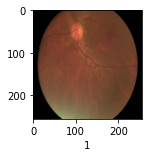

In [ ]:
def plot_sample(X, y, index):
    plt.figure(figsize = (15,2))
    plt.imshow(X[index])
    plt.xlabel(y[index])
plot_sample(X_test, y_test,3)   #plots test data with index 3 

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report    #classification report provides precision, recall and f1-score
print(classification_report(y_test,y_classes))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       838
           1       1.00      0.98      0.99       837

    accuracy                           0.99      1675
   macro avg       0.99      0.99      0.99      1675
weighted avg       0.99      0.99      0.99      1675



Text(69.0, 0.5, 'Truth')

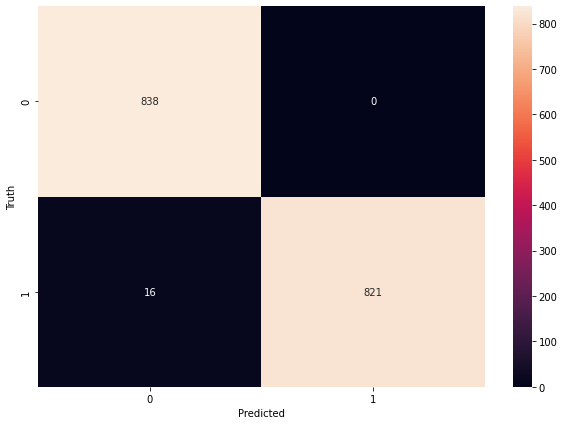

In [ ]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_classes)              #confusion matrix for better representation seaborn is used

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

## ROC curve

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score        #plotting ROC Curve
r_fpr, r_tpr, _ = roc_curve(y_test, y_classes)

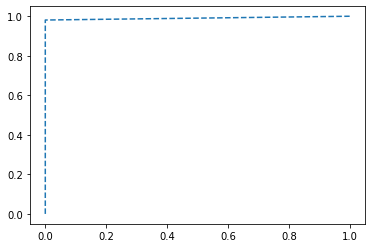

In [ ]:
import matplotlib.pyplot as plt
plt.plot(r_fpr, r_tpr, linestyle='--')

In [ ]:
m = tf.keras.metrics.SpecificityAtSensitivity(0.5)      #sensitivity is one
m.update_state(y_test, y_pred)
m.result().numpy()

1.0

## Creating and Training the BernoulliNB Model

In [49]:
from sklearn.naive_bayes import BernoulliNB         #Naive Bayes classifier for multivariate Bernoulli models.
from sklearn.pipeline import Pipeline               #Pipeline of transforms with a final estimator.
model = BernoulliNB()
pipe = Pipeline(steps =[
                        ('scaler', StandardScaler()),
                        ('model',model)
                    ])
X_train_flat=X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2]*X_train.shape[3])   #reshaping to 2d array
pipe.fit(X_train_flat, y_train)


Pipeline(steps=[('scaler', StandardScaler()), ('model', BernoulliNB())])

## Model Evaluation (average of 10 trials)
##### average accuracy on test data is 58%
##### f1 score of 0.57
##### precision for output 1 is 0.57
##### precision for output 0 is 0.57
##### recall for output 0 is 0.55
##### recall for output 1 is 0.56

In [52]:
X_test_flat=X_test.reshape(X_test.shape[0],X_train.shape[1]*X_train.shape[2]*X_train.shape[3])  #prediction
y_pred=pipe.predict(X_test_flat)


In [53]:
y_pred

array([1, 1, 1, ..., 1, 1, 0])

In [54]:
from sklearn.metrics import confusion_matrix , classification_report    #classification report provides precision, recall and f1-score
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.58      0.55      0.57       746
           1       0.57      0.60      0.59       745

    accuracy                           0.58      1491
   macro avg       0.58      0.58      0.58      1491
weighted avg       0.58      0.58      0.58      1491



## ROC Curve

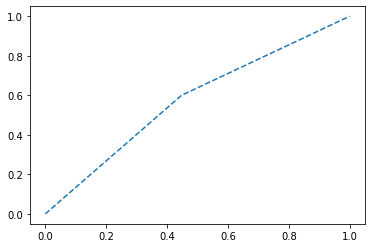

In [56]:
from sklearn.metrics import roc_curve, roc_auc_score        #plotting ROC Curve
r_fpr, r_tpr, _ = roc_curve(y_test, y_pred)
import matplotlib.pyplot as plt
plt.plot(r_fpr, r_tpr, linestyle='--')